**Kelompok - 26**
### Predict Students' Dropout and Academic Success

In [ ]:
    from google.colab import drive
    drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# STEP 1 — DATA COLLECTION & LOADING

import pandas as pd
import numpy as np

# Baca dataset (gunakan encoding dan delimiter yang sesuai)
df = pd.read_csv('/content/gdrive/MyDrive/UTS DASI/data.csv', sep=';', encoding='utf-8-sig')

# Normalisasi nama kolom menjadi snake_case
def to_snake(s):
    return s.strip().lower().replace(' ', '_').replace('(', '').replace(')', '').replace('/', '_').replace('-', '_').replace('__','_')

df.columns = [to_snake(c) for c in df.columns]

# Lihat info dasar
print("Ukuran dataset:", df.shape)
print("\nNama kolom:", df.columns.tolist())
print("\nInfo dataset:")
print(df.info())

# Cek missing values dan duplikasi
print("\nTotal missing values:", df.isna().sum().sum())
print("Total baris duplikat:", df.duplicated().sum())

# Cek distribusi target
print("\nDistribusi Target:")
print(df['target'].value_counts())


Ukuran dataset: (4424, 37)

Nama kolom: ['marital_status', 'application_mode', 'application_order', 'course', 'daytime_evening_attendance', 'previous_qualification', 'previous_qualification_grade', 'nacionality', "mother's_qualification", "father's_qualification", "mother's_occupation", "father's_occupation", 'admission_grade', 'displaced', 'educational_special_needs', 'debtor', 'tuition_fees_up_to_date', 'gender', 'scholarship_holder', 'age_at_enrollment', 'international', 'curricular_units_1st_sem_credited', 'curricular_units_1st_sem_enrolled', 'curricular_units_1st_sem_evaluations', 'curricular_units_1st_sem_approved', 'curricular_units_1st_sem_grade', 'curricular_units_1st_sem_without_evaluations', 'curricular_units_2nd_sem_credited', 'curricular_units_2nd_sem_enrolled', 'curricular_units_2nd_sem_evaluations', 'curricular_units_2nd_sem_approved', 'curricular_units_2nd_sem_grade', 'curricular_units_2nd_sem_without_evaluations', 'unemployment_rate', 'inflation_rate', 'gdp', 'target']

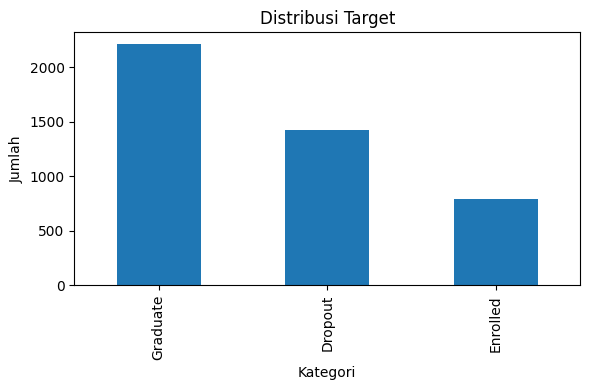

                                               count         mean  \
marital_status                                4424.0     1.178571   
application_mode                              4424.0    18.669078   
application_order                             4424.0     1.727848   
course                                        4424.0  8856.642631   
daytime_evening_attendance                    4424.0     0.890823   
previous_qualification                        4424.0     4.577758   
previous_qualification_grade                  4424.0   132.613314   
nacionality                                   4424.0     1.873192   
mother's_qualification                        4424.0    19.561935   
father's_qualification                        4424.0    22.275316   
mother's_occupation                           4424.0    10.960895   
father's_occupation                           4424.0    11.032324   
admission_grade                               4424.0   126.978119   
displaced                         

In [ ]:
# STEP 2 — EDA

import matplotlib.pyplot as plt

# 1. Bar chart distribusi target
plt.figure(figsize=(6,4))
df['target'].value_counts().plot(kind='bar')
plt.title('Distribusi Target')
plt.ylabel('Jumlah')
plt.xlabel('Kategori')
plt.tight_layout()
plt.show()

# 2. Statistik deskriptif
print(df.describe().T)

# 3. Korelasi antar fitur numerik
corr = df.select_dtypes(include=[np.number]).corr()
print("\nKorelasi antar fitur numerik (top 5):")
print(corr.head())


In [ ]:
# STEP 3 — PREPROCESSING

from sklearn.preprocessing import StandardScaler

# 1. Handling outliers dengan IQR (contoh untuk admission_grade)
col = 'admission_grade'
Q1 = df[col].quantile(0.25)
Q3 = df[col].quantile(0.75)
IQR = Q3 - Q1
df = df[(df[col] >= Q1 - 1.5*IQR) & (df[col] <= Q3 + 1.5*IQR)]

# 2. Feature scaling
num_cols = df.select_dtypes(include=[np.number]).columns
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

# 3. Encoding (jika ada kategori selain target)
cat_cols = df.select_dtypes(include=['object']).columns.drop('target', errors='ignore')
if len(cat_cols) > 0:
    df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

print("Ukuran dataset setelah preprocessing:", df.shape)


Ukuran dataset setelah preprocessing: (4338, 37)


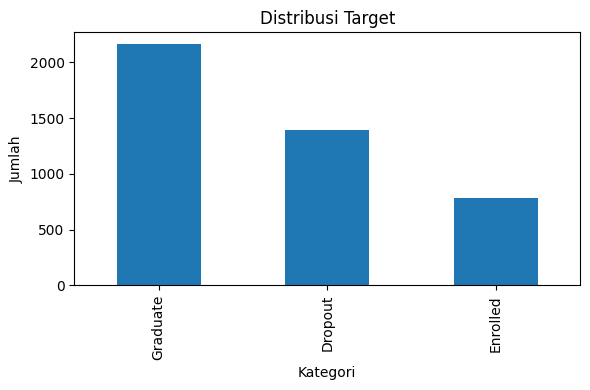

/tmp/ipython-input-543795714.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(groups, labels=df['target'].unique())


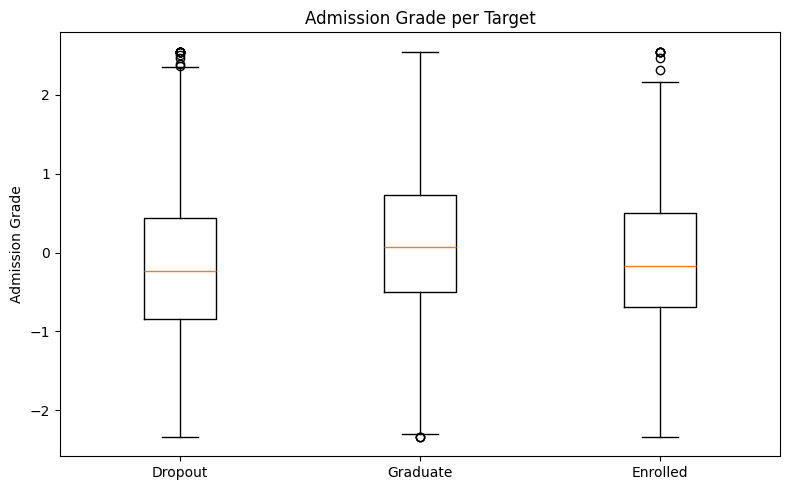

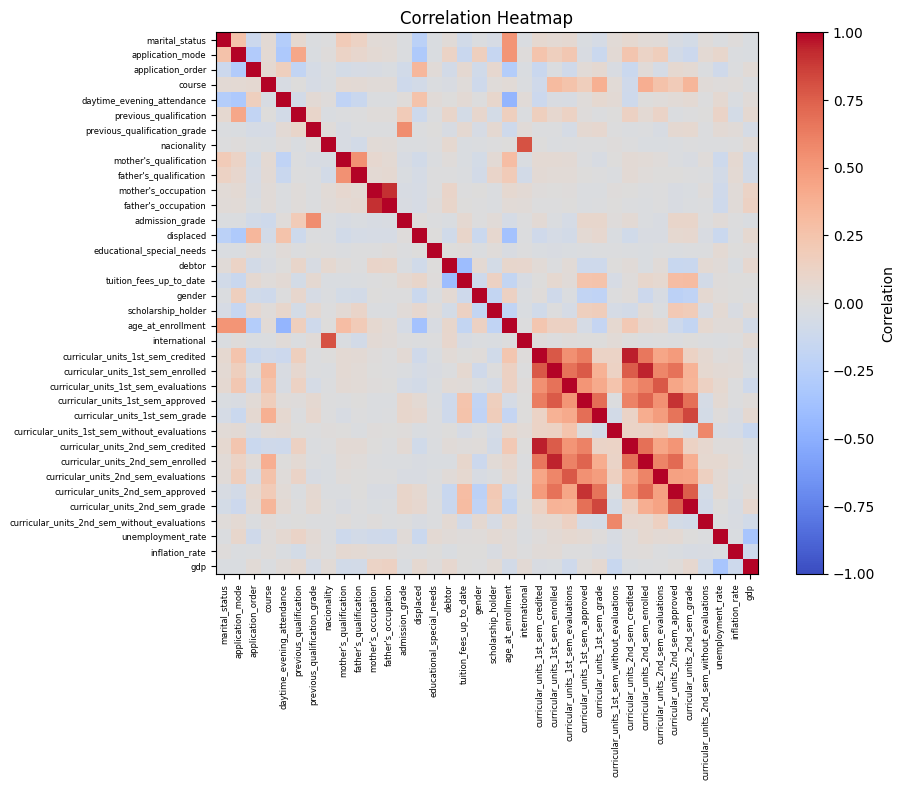

In [ ]:
# STEP 4 — VISUALISASI DATA

import matplotlib.pyplot as plt

# 1. Bar chart distribusi target
plt.figure(figsize=(6,4))
df['target'].value_counts().plot(kind='bar')
plt.title('Distribusi Target')
plt.xlabel('Kategori')
plt.ylabel('Jumlah')
plt.tight_layout()
plt.show()

# 2. Boxplot admission grade per target
plt.figure(figsize=(8,5))
groups = [df[df['target']==g]['admission_grade'] for g in df['target'].unique()]
plt.boxplot(groups, labels=df['target'].unique())
plt.title('Admission Grade per Target')
plt.ylabel('Admission Grade')
plt.tight_layout()
plt.show()

# 3. Heatmap korelasi numerik
import numpy as np
corr = df.select_dtypes(include=[np.number]).corr()
plt.figure(figsize=(10,8))
plt.imshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(label='Correlation')
plt.xticks(np.arange(len(corr.columns)), corr.columns, rotation=90, fontsize=6)
plt.yticks(np.arange(len(corr.columns)), corr.columns, fontsize=6)
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()


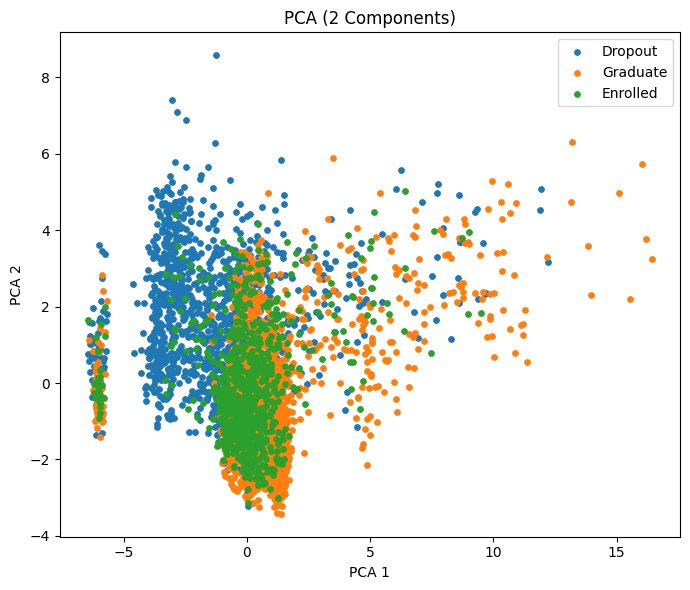

In [ ]:
# STEP 5 — PCA 2D
from sklearn.decomposition import PCA

num_cols = df.select_dtypes(include=[np.number]).columns
X_scaled = df[num_cols]

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(X_pca, columns=['pca1','pca2'])
pca_df['target'] = df['target'].values

# Plot PCA
plt.figure(figsize=(7,6))
for label in pca_df['target'].unique():
    subset = pca_df[pca_df['target'] == label]
    plt.scatter(subset['pca1'], subset['pca2'], s=15, label=label)
plt.title('PCA (2 Components)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# STEP 6 — UJI STATISTIK

from scipy.stats import levene, f_oneway, kruskal, mannwhitneyu, spearmanr

# Ambil kolom admission grade dan target
col = 'admission_grade'
groups = [df[df['target']==g][col] for g in df['target'].unique()]

# Levene (uji homogenitas varians)
levene_stat, levene_p = levene(*groups)
print("Levene Test p-value:", levene_p)

# ANOVA
f_stat, f_p = f_oneway(*groups)
print("ANOVA p-value:", f_p)

# Kruskal-Wallis (non-parametrik)
kw_stat, kw_p = kruskal(*groups)
print("Kruskal-Wallis p-value:", kw_p)

# Mann-Whitney (Graduate vs Dropout saja)
g1 = df[df['target']=='Graduate'][col]
g2 = df[df['target']=='Dropout'][col]
u_stat, u_p = mannwhitneyu(g1, g2)
print("Mann-Whitney U p-value:", u_p)

# Spearman correlation (admission_grade vs curricular grade)
curr_col = [c for c in df.columns if 'curricular_units_1st_sem_grade' in c][0]
rho, p_spear = spearmanr(df[col], df[curr_col])
print(f"Spearman correlation (admission vs {curr_col}): rho={rho}, p={p_spear}")


Levene Test p-value: 0.00014682076322116775
ANOVA p-value: 1.1440976653298672e-17
Kruskal-Wallis p-value: 1.198432535771377e-16
Mann-Whitney U p-value: 1.950086030245911e-15
Spearman correlation (admission vs curricular_units_1st_sem_grade): rho=0.20930331367596358, p=3.8224901832642236e-44


In [ ]:
# STEP 7 — INTERPRETASI HASIL

# Interpretasi sederhana berbasis output uji statistik:
if f_p < 0.05:
    print("Terdapat perbedaan signifikan pada admission_grade antar kategori target (ANOVA).")
else:
    print("Tidak ada perbedaan signifikan (ANOVA).")

if kw_p < 0.05:
    print("Hasil Kruskal-Wallis juga signifikan, memperkuat hasil ANOVA.")

if u_p < 0.05:
    print("Perbedaan signifikan antara Graduate dan Dropout (Mann-Whitney).")

if p_spear < 0.05:
    print(f"Ada korelasi signifikan antara admission_grade dan {curr_col} (Spearman).")


Terdapat perbedaan signifikan pada admission_grade antar kategori target (ANOVA).
Hasil Kruskal-Wallis juga signifikan, memperkuat hasil ANOVA.
Perbedaan signifikan antara Graduate dan Dropout (Mann-Whitney).
Ada korelasi signifikan antara admission_grade dan curricular_units_1st_sem_grade (Spearman).
